In [181]:
import os
import sys
import sqlite3

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

# Ensure the parent directory is in the path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

import settings

In [182]:
with sqlite3.connect(settings.DATABASE_PATH) as conn:
    df = pd.read_sql(
        f"""
            SELECT * FROM Matches
        """,
        conn,
    )

In [183]:
df = df.dropna(subset=["score"]).copy()
df["home_score"] = df["score"].str.split(":").str[0].astype(int)
df["away_score"] = df["score"].str.split(":").str[1].astype(int)
df["home_win"] = (df["home_score"] > df["away_score"]).astype(int)
df["away_win"] = (df["home_score"] < df["away_score"]).astype(int)
df["tie"] = (df["home_score"] == df["away_score"]).astype(int)
df["difference_score"] = abs(df["home_score"] - df["away_score"])


In [184]:
def adjust_date(row):
    """
    Adjust the date by adding the correct century based on the season.
    If the date"s year is less than the season"s end year, use the start year,
    otherwise use the end year of the season.

    :param row: A row from the DataFrame containing "date" and "season".
    :return: Adjusted date string in the format DD/MM/YYYY.
    """
    start_year = int(row["season"].split("-")[0])
    end_year = int(row["season"].split("-")[1])
    date_year = int(row["date"].split("/")[-1])

    if date_year == start_year % 100:
        return row["date"][:-2] + str(start_year)
    else:
        return row["date"][:-2] + str(end_year)


df["date"] = df.apply(adjust_date, axis=1)
df = df.dropna(subset=["date"])
df["date"] = pd.to_datetime(df["date"], format="%m/%d/%Y")

In [185]:
df = df.dropna(subset=["score"])
df["season"] = df["season"].str.split("-").str[0].astype(int)

conditions = [
    (df['home_win'] == 1),
    (df['tie'] == 1),
    (df['away_win'] == 1)
]

choices = [1, 0, -1]

df['result'] = np.select(conditions, choices, default=None)


In [212]:
def calculate_team_results(df, max_matchday=None):
    """
    Calculates team results up to a specific matchday.
    Has been modified to include just the necessary columns for the model.
    
    :param df: DataFrame with match data
    :param max_matchday: Only consider matches up to this matchday (exclusive)
    :return: DataFrame with team points
    """
    if max_matchday is not None:
        df = df[df['matchday'] < max_matchday].copy()
    
    df_results = (
        pd.concat(
            [
                df.groupby(["season", "home_team"])
                .agg(
                    W=("home_win", "sum"),
                    L=("away_win", "sum"),
                    T=("tie", "sum"),
                )
                .reset_index()
                .rename(columns={"home_team": "team"}),
                df.groupby(["season", "away_team"])
                .agg(

                    W=("away_win", "sum"),
                    L=("home_win", "sum"),
                    T=("tie", "sum"),
                )
                .reset_index()
                .rename(columns={"away_team": "team"}),
            ]
        )
        .groupby(["season", "team"])
        .sum()
        .reset_index()
    )

    df_results["points"] = df_results["W"] * 3 + df_results["T"]

    df_results = df_results.sort_values(
        by=["season", "points"],
        ascending=[False, False],
    ).reset_index(drop=True)

    df_results["rank"] = (
        df_results.groupby(["season"])["points"]
        .rank("first", ascending=False)
        .astype(int)
    )

    df_results = df_results[
        [
            "season",
            "team",
            "points",
        ]
    ]
    return df_results

In [187]:
def team_confrontations(df, team1, team2):
    df_confrontations = df.loc[
        ((df["home_team"] == team1) | (df["away_team"] == team1))
        & ((df["home_team"] == team2) | (df["away_team"] == team2))
    ]

    return df_confrontations

def won_games(df, team: str):
    """
    Returns those winning games for a given team
    """
    home_wins = (df["home_team"] == team) & (df["home_win"] == 1)
    away_wins = (df["away_team"] == team) & (df["away_win"] == 1)
    return df[home_wins | away_wins]


def lost_games(df, team: str):
    """
    Returns those winning games for a given team
    """
    home_lost = (df["home_team"] == team) & (df["home_win"] == 0)
    away_lost = (df["away_team"] == team) & (df["away_win"] == 0)
    tie_games = (df["home_team"] == team) & (df["tie"] == 1) | (df["away_team"] == team) & (df["tie"] == 1)

    return df[(home_lost | away_lost) & ~tie_games]


In [188]:
def win_lost_index(row, df_conf_dict):
    """
    Calculates win and loss punctuation between two teams for the row's season,
    using a precomputed dictionary of relevant confrontations for each season.

    This function returns a victory and lose punctuation between 2 teams.
    It is given by 1 / ((currentseason - season)^2 + 1)
    This function has a maximum in currentseason and it deacreses as season increase
    Giving more importance to recent matches.
    It is symmetric for both teams, so win_team1 = lost_team2.

    :param row: A row from the DataFrame containing "season", "home_team" and "away_team".
    :param df_conf_dict: A dictionary containing relevant confrontations for each season.
    :return: A tuple with the win and loss punctuation for the row's season.
    """
    season = row["season"]
    team1 = row["home_team"]
    team2 = row["away_team"]
    
    df_conf = df_conf_dict.get((team1, team2), pd.DataFrame())
    
    df_won = won_games(df_conf, team1)
    if not df_won.empty:
        df_won["win_punct"] = 1 / ((season - df_won["season"].astype(int)) ** 2 + 1)
        win_punct = df_won["win_punct"].sum()
    else:
        win_punct = 0
    
    df_lost = lost_games(df_conf, team1)
    if not df_lost.empty:
        df_lost["lost_punct"] = 1 / ((season - df_lost["season"].astype(int)) ** 2 + 1)
        lost_punct = df_lost["lost_punct"].sum()
    else:
        lost_punct = 0
    
    return win_punct, lost_punct

def inform_win_lost_index(df, df_calculate):
    """
    Adds win and loss punctuation to the DataFrame for each row's season.

    :param df: DataFrame containing match data for all teams.
    :param df_calculate: DataFrame containing the matches to calculate the win and loss punctuation.
    :return: DataFrame with the win and loss punctuation for each row's season.
    """
    max_season = df_calculate["season"].max()
    df_recent = df[df["season"] >= (max_season - 20)].copy()
    
    teams = df_calculate[["home_team", "away_team"]].drop_duplicates()
    df_conf_dict = {
        (team1, team2): team_confrontations(df_recent, team1, team2)
        for team1, team2 in zip(teams["home_team"], teams["away_team"])
    }
    
    df_calculate[["win_punct", "lost_punct"]] = df_calculate.apply(
        lambda row: win_lost_index(row, df_conf_dict),
        axis=1, result_type="expand"
    )
    
    return df_calculate


In [189]:
def difference_points(row, df_results_dict):
    """
    Calculates the difference in points between home and away teams
    considering only matches before the current matchday.
    
    :param row: DataFrame row with home_team, away_team, season, and matchday
    :param df_results_dict: Dictionary of {season: {matchday: results_df}}
    :return: Point difference between home and away team
    """
    season = row['season']
    matchday = row['matchday']
    
    results_key = (season, matchday)
    if results_key not in df_results_dict:
        return 0
    
    results_df = df_results_dict[results_key]
    
    try:
        home_team_points = results_df.loc[results_df['team'] == row['home_team'], 'points'].iloc[0]
        away_team_points = results_df.loc[results_df['team'] == row['away_team'], 'points'].iloc[0]
        return home_team_points - away_team_points
    except (KeyError, IndexError):
        return 0

def inform_relatives_points(df, df_calculate):
    """
    Calculates relative points for each match considering only previous matchdays.
    
    :param df: Complete DataFrame with all matches
    :param df_calculate: DataFrame with matches to calculate features for
    :return: DataFrame with added relative points features
    """
    df_results_dict = {}
    
    for season in df_calculate['season'].unique():
        season_data = df[df['season'] == season].copy()
        
        for matchday in df_calculate[df_calculate['season'] == season]['matchday'].unique():
            results = calculate_team_results(season_data, max_matchday=matchday)
            df_results_dict[(season, matchday)] = results
    
    df_calculate['points_relative'] = df_calculate.apply(
        lambda row: difference_points(row, df_results_dict), axis=1
    )
    
    df_calculate['points_relative_index'] = df_calculate.apply(
        lambda row: row['points_relative'] * (row['matchday']**2 / (row['matchday']**2 + 38))
        if row['matchday'] > 0 else 0, 
        axis=1
    )
    
    return df_calculate

In [190]:
def calculate_results(df):
    """
    Precalculates results for all matches.
    """
    home_results = df[['matchday', 'season', 'home_team', 'home_win', 'tie']].copy()
    home_results['team'] = home_results['home_team']
    home_results['Result'] = np.where(
        home_results['tie'] == 1, 'T',
        np.where(home_results['home_win'] == 1, 'W', 'L')
    )
    
    away_results = df[['matchday', 'season', 'away_team', 'away_win', 'tie']].copy()
    away_results['team'] = away_results['away_team']
    away_results['Result'] = np.where(
        away_results['tie'] == 1, 'T',
        np.where(away_results['away_win'] == 1, 'W', 'L')
    )
    
    all_results = pd.concat([
        home_results[['matchday', 'season', 'team', 'Result']],
        away_results[['matchday', 'season', 'team', 'Result']]
    ]).sort_values(['team', 'season', 'matchday'], ascending=[True, True, False])
    
    return all_results

def get_last_5_results(all_results, matchday, team, season):
    """
    Gets all available results up to 5 for a team in a season.
    """
    mask = (all_results['team'] == team) & \
           (all_results['season'] == season) & \
           (all_results['matchday'] < matchday)
    
    results = all_results[mask]['Result'].head(5).tolist()
    return results, len(results)

def convert_results_to_points(results_tuple):
    """
    Converts results to points with correction factor for fewer than 5 matches.
    """
    results, num_matches = results_tuple
    if num_matches == 0:
        return 0
    
    points_map = {'W': 3, 'L': 0, 'T': 1}
    total_points = sum(points_map[result] for result in results)
    
    correction_factor = 5 / num_matches
    corrected_points = total_points * correction_factor
    
    return round(corrected_points, 2) 

def last5index(df, df_predict):
    """
    Calculates the last 5 matches index for all teams with correction for fewer matches.
    """
    # df_calculate has the last 5 matches results so takes the same season as df_predict and the matchday is less than the matchday of the match to predict
    df_calculate = df.loc[(df['season'] == df_predict['season'].max()) & (df['matchday'] < df_predict['matchday'].max()) & (df['matchday'] >=df_predict['matchday'].max() - 5)].copy()
    
    all_results = calculate_results(df_calculate)

    df_predict['last5_home'] = df_predict.apply(
        lambda row: get_last_5_results(all_results, row['matchday'], row['home_team'], row['season']), 
        axis=1
    )
    
    df_predict['last5_away'] = df_predict.apply(
        lambda row: get_last_5_results(all_results,  row['matchday'], row['away_team'], row['season']), 
        axis=1
    )
    df_predict['last5_home'] = df_predict['last5_home'].apply(convert_results_to_points)
    df_predict['last5_away'] = df_predict['last5_away'].apply(convert_results_to_points)
    
    return df_predict



In [ ]:
# Idea: Punts ultima temporada
def last_season_position(df, df_predict):
    """
    Adds the last season points in a new column.
    """
    df_calculate = df.loc[(df['season'] == df_predict['season'].max() - 1)].copy()
    df_results = calculate_team_results(df_calculate)
    
    df_predict['last_season_points_home'] = df_predict.apply(
        lambda row: df_results.loc[df_results['team'] == row['home_team'], 'points'].iloc[0] if row['home_team'] in df_results['team'].values else 0,
        axis=1
    )
    
    df_predict['last_season_points_away'] = df_predict.apply(
        lambda row: df_results.loc[df_results['team'] == row['away_team'], 'points'].iloc[0] if row['away_team'] in df_results['team'].values else 0,
        axis=1
    )

    #if in a row value is 0, it means that the team was not in the last season, so we will fill it with the average of the last season minus 20
    # Improvement, calcualte mean of the teams that ascend to the league
    df_predict['last_season_points_home'] = df_predict['last_season_points_home'].replace(0, df_results['points'].mean() - 20)
    df_predict['last_season_points_away'] = df_predict['last_season_points_away'].replace(0, df_results['points'].mean() - 20)
    return df_predict

,season,division,matchday,date,time,home_team,away_team,score,home_score,away_score,home_win,away_win,tie,difference_score,result,last_season_points_home,last_season_points_away
16236,1996,1,1,1996-08-31,None,Dep. La Coruña,Real Madrid,1:1,1,1,0,0,1,0,0,35.000000,92.000000
16237,1996,1,1,1996-09-01,None,Atlético Madrid,Celta de Vigo,2:0,2,0,1,0,0,2,1,78.000000,51.000000
16238,1996,1,1,1996-09-01,None,Real Betis,Athletic,3:0,3,0,1,0,0,3,1,84.000000,55.000000
16239,1996,1,1,1996-09-01,None,Hércules CF,CF Extremadura,2:1,2,1,1,0,0,1,1,34.761905,34.761905
16240,1996,1,1,1996-09-01,None,Racing,Valencia,3:2,3,2,1,0,0,1,1,44.000000,77.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45623,2015,2,42,2016-06-04,8:30 PM,Gimnàstic,Alavés,1:1,1,1,0,0,1,0,0,34.761905,53.000000
45624,2015,2,42,2016-06-04,8:30 PM,Real Oviedo,CA Osasuna,0:5,0,5,0,1,0,5,-1,34.761905,45.000000
45625,2015,2,42,2016-06-04,8:30 PM,Llagostera,Real Zaragoza,6:2,6,2,1,0,0,4,1,57.000000,61.000000
45626,2015,2,42,2016-06-04,8:30 PM,CD Mirandés,CD Leganés,0:1,0,1,0,1,0,1,-1,59.000000,56.000000


## Pretreatment

In [ ]:
# Data that will be used for training
train_season = 2015
depth = 20 # Number of seasons to consider for training

df_train = df.loc[(df["season"] > (train_season - depth)) & (df["season"] <= train_season)].copy()

df_train = inform_relatives_points(df, df_train)
print("Relative points calculated")
df_train = inform_win_lost_index(df, df_train)
print("Win and loss index calculated")
df_train = last5index(df, df_train)
print("Last 5 index calculated")
df_train = last_season_position(df, df_train)
print("Last season position calculated")


Relative points calculated
Win and loss index calculated
Last 5 index calculated


## Train

In [226]:
features = ["win_punct", "lost_punct", "points_relative_index", "last5_home", "last5_away", "last_season_points_home", "last_season_points_away"]
target = "result"

x_train = df_train[features]
y_train = df_train[target]

le = LabelEncoder()
y_train = le.fit_transform(y_train)  

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=40)

clf = GradientBoostingClassifier()
clf.fit(x_train, y_train)

y_val_pred = clf.predict(x_val)
validation_accuracy = (y_val_pred == y_val).mean()
print(f"Validation Accuracy: {validation_accuracy:.2%}")

#Save the model
import joblib
joblib.dump(clf, "../models/model2-11-20s-7f.pkl")


Validation Accuracy: 70.90%


['../models/model2-11-20s-7f.pkl']

## Performance

=== Model Performance Analysis ===



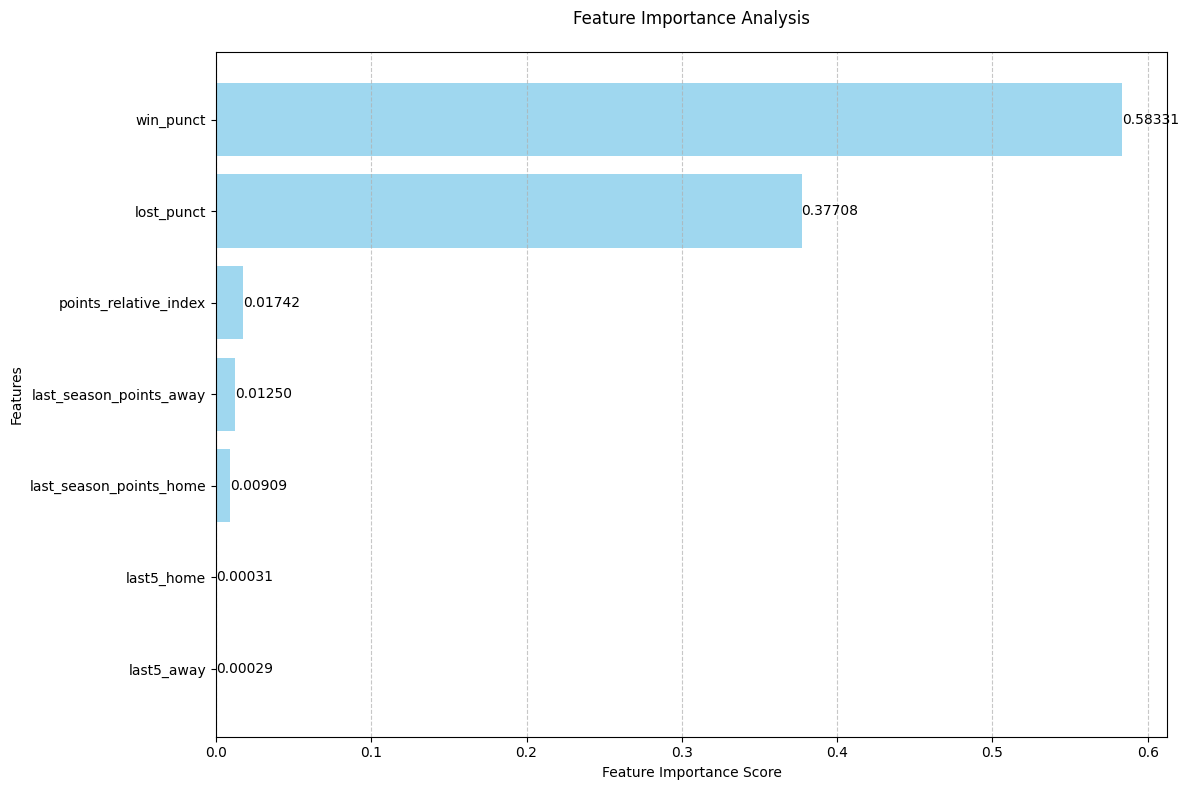

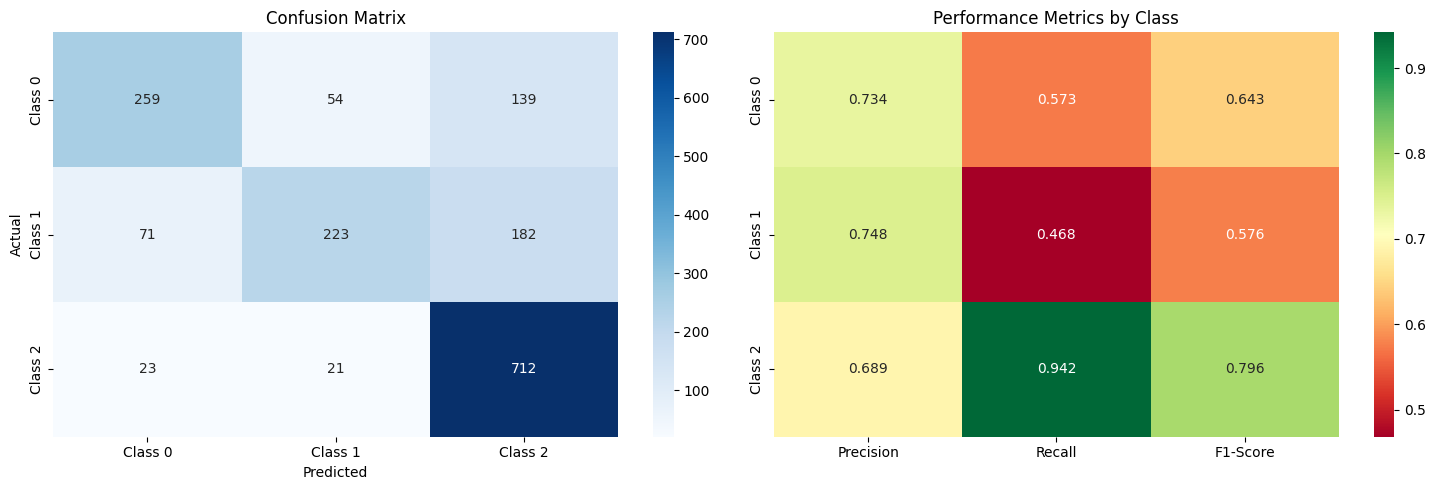


Detailed Classification Report:
              precision    recall  f1-score   support

     Class 0       0.73      0.57      0.64       452
     Class 1       0.75      0.47      0.58       476
     Class 2       0.69      0.94      0.80       756

    accuracy                           0.71      1684
   macro avg       0.72      0.66      0.67      1684
weighted avg       0.72      0.71      0.69      1684


Overall Model Accuracy: 0.709


In [227]:

def plot_feature_importance(feature_importance, figsize=(12, 8)):
    """
    Creates an enhanced feature importance visualization
    """
    plt.figure(figsize=figsize)
    
    bars = plt.barh(feature_importance["feature"], 
                   feature_importance["importance"], 
                   color='skyblue',
                   alpha=0.8)
    
    for bar in bars:
        width = bar.get_width()
        plt.text(width, 
                bar.get_y() + bar.get_height()/2,
                f'{width:.5f}',
                ha='left',
                va='center',
                fontsize=10)
    
    plt.xlabel("Feature Importance Score")
    plt.ylabel("Features")
    plt.title("Feature Importance Analysis", pad=20)
    
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.gca().invert_yaxis()
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix_analysis(y_true, y_pred, clf, figsize=(15, 5)):
    """
    Creates a comprehensive confusion matrix analysis with metrics
    """
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    classes = clf.classes_
    class_names = [f'Class {c}' if isinstance(c, (int, np.integer)) else str(c) for c in classes]
    
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    sns.heatmap(conf_matrix, 
                annot=True, 
                fmt='d', 
                cmap='Blues', 
                xticklabels=class_names,
                yticklabels=class_names,
                ax=ax1)
    ax1.set_xlabel("Predicted")
    ax1.set_ylabel("Actual")
    ax1.set_title("Confusion Matrix")
    
    metrics_data = pd.DataFrame({
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }, index=class_names)
    
    sns.heatmap(metrics_data, 
                annot=True, 
                fmt='.3f', 
                cmap='RdYlGn',
                ax=ax2)
    ax2.set_title("Performance Metrics by Class")
    
    plt.tight_layout()
    plt.show()
    
    print("\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

def analyze_model_performance(feature_importance, y_true, y_pred, clf):
    """
    Performs comprehensive model analysis
    """
    print("=== Model Performance Analysis ===\n")
    
    plot_feature_importance(feature_importance)
    plot_confusion_matrix_analysis(y_true, y_pred, clf)
    
    accuracy = (y_true == y_pred).mean()
    print(f"\nOverall Model Accuracy: {accuracy:.3f}")

feature_importance = pd.DataFrame(
    {
        "feature": features,
        "importance": clf.feature_importances_,
    }
)
feature_importance = feature_importance.sort_values("importance", ascending=False)
analyze_model_performance(feature_importance, y_val, y_val_pred, clf)

## Example of usage

In [229]:
model_path = "../models/model2-11-20s-7f.pkl"

if os.path.exists(model_path):
    clf = joblib.load(model_path)
else:
    print(f"Model file not found at {model_path}, uncomment the previous cell to train the model")

In [251]:
season_to_predict = 2020
matchday_to_predict = 12
df_predict = df.loc[(df["season"] == season_to_predict) & (df["matchday"] == matchday_to_predict) & (df["division"] == 1)].copy()

df_predict = inform_relatives_points(df, df_predict)
df_predict = inform_win_lost_index(df, df_predict)
df_predict = last5index(df, df_predict)
df_predict = last_season_position(df, df_predict)
x_predict = df_predict[features]

y_predict = clf.predict(x_predict)
y_predict = le.inverse_transform(y_predict)
df_predict["prediction"] = y_predict
df_predict["correct"] = df_predict["result"] == df_predict["prediction"]
print(df_predict["correct"].sum() / df_predict.shape[0] * 100)

df_predict

90.0


,season,division,matchday,date,time,home_team,away_team,score,home_score,away_score,...,points_relative,points_relative_index,win_punct,lost_punct,last5_home,last5_away,last_season_points_home,last_season_points_away,prediction,correct
25548,2020,1,12,2020-12-04,9:00 PM,Athletic,Celta de Vigo,0:2,0,2,...,3,2.373626,1.173188,1.613409,7.0,5.0,51,37,1,False
25549,2020,1,12,2020-12-05,2:00 PM,Levante,Getafe,3:0,3,0,...,-4,-3.164835,1.902227,1.649155,5.0,3.0,49,54,1,True
25550,2020,1,12,2020-12-05,4:15 PM,Sevilla FC,Real Madrid,0:1,0,1,...,-1,-0.791209,0.470486,2.576519,9.0,7.0,70,87,-1,True
25551,2020,1,12,2020-12-05,6:30 PM,Atlético Madrid,Real Valladolid,2:0,2,0,...,17,13.450549,2.999570,0.020318,15.0,7.0,70,42,1,True
25552,2020,1,12,2020-12-05,9:00 PM,Cádiz CF,Barcelona,2:1,2,1,...,-5,-3.956044,1.000000,0.008850,5.0,7.0,69,82,1,True
25553,2020,1,12,2020-12-06,2:00 PM,Granada CF,SD Huesca,3:3,3,3,...,10,7.912088,0.109901,1.100000,4.0,2.0,56,70,0,True
25554,2020,1,12,2020-12-06,4:15 PM,CA Osasuna,Real Betis,0:2,0,2,...,-1,-0.791209,0.105673,2.703613,4.0,3.0,52,41,-1,True
25555,2020,1,12,2020-12-06,6:30 PM,Villarreal,Elche CF,0:0,0,0,...,7,5.538462,0.047027,0.030769,9.0,6.0,60,61,0,True
25556,2020,1,12,2020-12-06,9:00 PM,Alavés,Real Sociedad,0:0,0,0,...,-11,-8.703297,0.781552,1.974701,9.0,13.0,39,56,0,True
25557,2020,1,12,2020-12-07,9:00 PM,SD Eibar,Valencia,0:0,0,0,...,1,0.791209,0.917647,1.592516,8.0,5.0,42,53,0,True


In [252]:
df_predict_quiniela = df_predict[["home_team", "away_team", "result", "prediction", "correct"]].copy()
# use 1 X 2 instead of result
df_predict_quiniela["result"] = df_predict_quiniela["result"].map({1: "1", 0: "X", -1: "2"})
df_predict_quiniela["prediction"] = df_predict_quiniela["prediction"].map({1: "1", 0: "X", -1: "2"})
df_predict_quiniela

,home_team,away_team,result,prediction,correct
25548,Athletic,Celta de Vigo,2,1,False
25549,Levante,Getafe,1,1,True
25550,Sevilla FC,Real Madrid,2,2,True
25551,Atlético Madrid,Real Valladolid,1,1,True
25552,Cádiz CF,Barcelona,1,1,True
25553,Granada CF,SD Huesca,X,X,True
25554,CA Osasuna,Real Betis,2,2,True
25555,Villarreal,Elche CF,X,X,True
25556,Alavés,Real Sociedad,X,X,True
25557,SD Eibar,Valencia,X,X,True
